# Chapter 116: QSVT

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import Estimator
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp
from IPython.display import display
from numpy.polynomial.chebyshev import Chebyshev
from numpy.polynomial import Polynomial
import pyqsp
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
from Chapter17_QSVT_functions import (myQSVT, get_inverse_phases,SunderhaufPolynomial,angles_to_polynomial,
                                      qsp_unitary_reflection, plot_approximation_comparison)

## SVD

In [5]:
A = np.array([[0.1, 0.2], [0.2, 0.4]])
U, S, Vh = np.linalg.svd(A,compute_uv=True)

print("Singular values of A:", S)
print("Left singular vectors (U):", U)
print("Right singular vectors (Vh):", Vh)

Singular values of A: [5.00000000e-01 2.64734348e-17]
Left singular vectors (U): [[-0.4472136  -0.89442719]
 [-0.89442719  0.4472136 ]]
Right singular vectors (Vh): [[-0.4472136  -0.89442719]
 [-0.89442719  0.4472136 ]]


## SVD always exists

In [ ]:
A = np.array([[2, 1], [0, 2]])
U, S, Vh = np.linalg.svd(A,compute_uv=True)

print("Singular values of A:\n", S)
print("Left singular vectors (U):\n", U)
print("Right singular vectors (Vh):\n", Vh)

print("A ~ \n", U @ np.diag(S) @ Vh)  # Reconstruct A

## Chebyshev polynomials

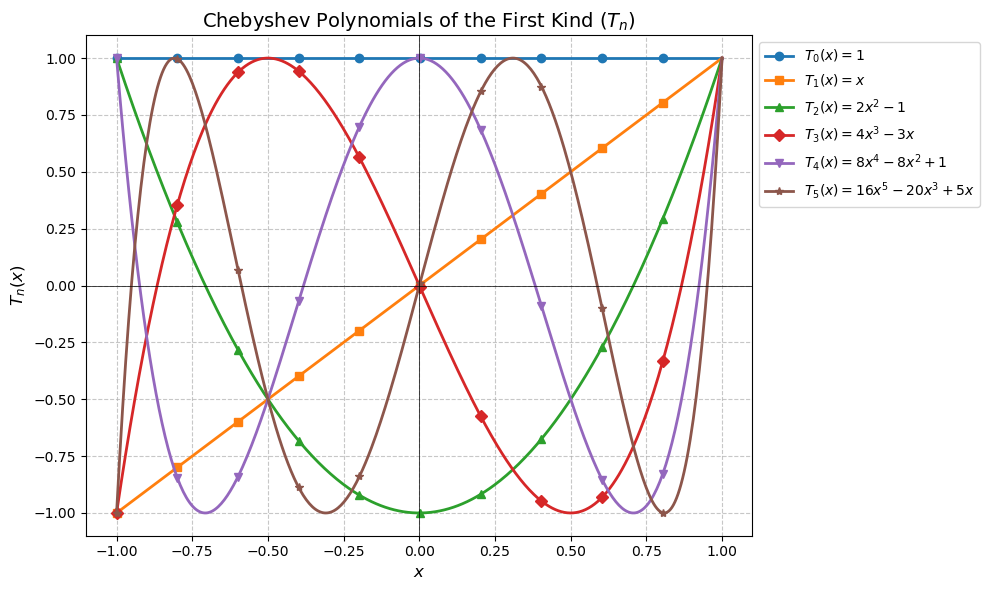

In [30]:
# Define the x range from -1 to 1
x = np.linspace(-1, 1, 400)

# Define the first 6 Chebyshev polynomials
T0 = np.ones_like(x)
T1 = x
T2 = 2*x**2 - 1
T3 = 4*x**3 - 3*x
T4 = 8*x**4 - 8*x**2 + 1
T5 = 16*x**5 - 20*x**3 + 5*x

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, T0, label='$T_0(x) = 1$', linewidth=2, marker='o', markevery=40)
plt.plot(x, T1, label='$T_1(x) = x$', linewidth=2, marker='s', markevery=40)
plt.plot(x, T2, label='$T_2(x) = 2x^2 - 1$', linewidth=2, marker='^', markevery=40)
plt.plot(x, T3, label='$T_3(x) = 4x^3 - 3x$', linewidth=2, marker='D', markevery=40)
plt.plot(x, T4, label='$T_4(x) = 8x^4 - 8x^2 + 1$', linewidth=2, marker='v', markevery=40)
plt.plot(x, T5, label='$T_5(x) = 16x^5 - 20x^3 + 5x$', linewidth=2, marker='*', markevery=40)

# Formatting the plot
plt.title('Chebyshev Polynomials of the First Kind ($T_n$)', fontsize=14)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$T_n(x)$', fontsize=12)
plt.axhline(0, color='black', linewidth=0.5) # x-axis
plt.axvline(0, color='black', linewidth=0.5) # y-axis
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(-1.1, 1.1)
plt.tight_layout()

plt.show()

## From Monomial to Chebyshev

In [12]:
cheb_coeffs = [0,0,0.5,0,0.1] 
poly = Chebyshev(cheb_coeffs)
phases_wx = QuantumSignalProcessingPhases(poly)
phases_ref = np.copy(phases_wx)
phases_ref[0] += np.pi/4
d = len(cheb_coeffs) - 1 # Degree is 4
if d % 2 == 0:
    phases_ref[-1] += np.pi/4
else:
    phases_ref[-1] -= np.pi/4

print("Reflection Phases:")
print([round(float(phi), 3) for phi in phases_ref])

Reflection Phases:
[-0.732, 0.264, 0.008, 0.264, 0.839]


In [ ]:
W = qsp_unitary_reflection(phases_ref)

## From Chebyshev to Monomials

In [9]:
# 1. Define the coefficients in the Chebyshev basis
# Let's say we have 1*T_0(x) + 0*T_1(x) + 0.5*T_2(x)
cheb_coeffs = [1, 0, 0.5] 
p_cheb = Chebyshev(cheb_coeffs)

# 2. Convert to the Standard Power basis (Polynomial)
p_standard = p_cheb.convert(kind=Polynomial)

# 3. Output the results
print(f"Chebyshev Polynomial: {p_cheb}")
print(f"Standard Basis Coefficients: {p_standard.coef}")

# Interpretation: 
# T_0 is 1, T_2 is (2x^2 - 1). 
# So: 1(1) + 0.5(2x^2 - 1) = 1 + x^2 - 0.5 = 0.5 + x^2
# Result should be [0.5, 0.0, 1.0]

Chebyshev Polynomial: 1.0 + 0.0 T_1(x) + 0.5 T_2(x)
Standard Basis Coefficients: [0.5 0.  1. ]


In [13]:
# T_2(x) = 2x^2 - 1
pcoefs_cheb = [0, 0, 1]  
# Create Chebyshev polynomial object
poly = Chebyshev(pcoefs_cheb)

# Compute QSP phase angles
QiskitPhases = QuantumSignalProcessingPhases(poly)
print("Qiskit QSP Phases (Wx):", [round(float(phi), 3) for phi in QiskitPhases])


Qiskit QSP Phases (Wx): [-0.79, 0.0, 0.78]


## Sunderhauf approximation

In [6]:
eps = 0.05
delta = 0.1

# Compute optimal degree
d = SunderhaufPolynomial.mindegree(eps, delta)
print(f"Optimal degree: {d}")  

# Get Chebyshev polynomial
cheb_poly = SunderhaufPolynomial.poly(d, delta)
scaling_factor = 0.9*delta 
cheb_poly_scaled = cheb_poly * scaling_factor

print(f"Chebyshev polynomial\n", cheb_poly_scaled)


Optimal degree: 53
Chebyshev polynomial
 0.0 + 0.17445891 T_1(x) + 0.0 T_2(x) - 0.16340538 T_3(x) + 0.0 T_4(x) +
0.15243747 T_5(x) + 0.0 T_6(x) - 0.14161102 T_7(x) + 0.0 T_8(x) +
0.13098002 T_9(x) + 0.0 T_10(x) - 0.12059597 T_11(x) + 0.0 T_12(x) +
0.11050721 T_13(x) + 0.0 T_14(x) - 0.10075831 T_15(x) + 0.0 T_16(x) +
0.09138964 T_17(x) + 0.0 T_18(x) - 0.08243684 T_19(x) + 0.0 T_20(x) +
0.07393051 T_21(x) + 0.0 T_22(x) - 0.06589596 T_23(x) + 0.0 T_24(x) +
0.05835302 T_25(x) + 0.0 T_26(x) - 0.05131593 T_27(x) + 0.0 T_28(x) +
0.0447934 T_29(x) + 0.0 T_30(x) - 0.03878868 T_31(x) + 0.0 T_32(x) +
0.03329978 T_33(x) + 0.0 T_34(x) - 0.02831969 T_35(x) + 0.0 T_36(x) +
0.02383675 T_37(x) + 0.0 T_38(x) - 0.01983505 T_39(x) + 0.0 T_40(x) +
0.01629488 T_41(x) + 0.0 T_42(x) - 0.0131932 T_43(x) + 0.0 T_44(x) +
0.01050422 T_45(x) + 0.0 T_46(x) - 0.00819992 T_47(x) + 0.0 T_48(x) +
0.00625058 T_49(x) + 0.0 T_50(x) - 0.00462536 T_51(x) + 0.0 T_52(x) +
0.00633611 T_53(x)


## Plot the two functions

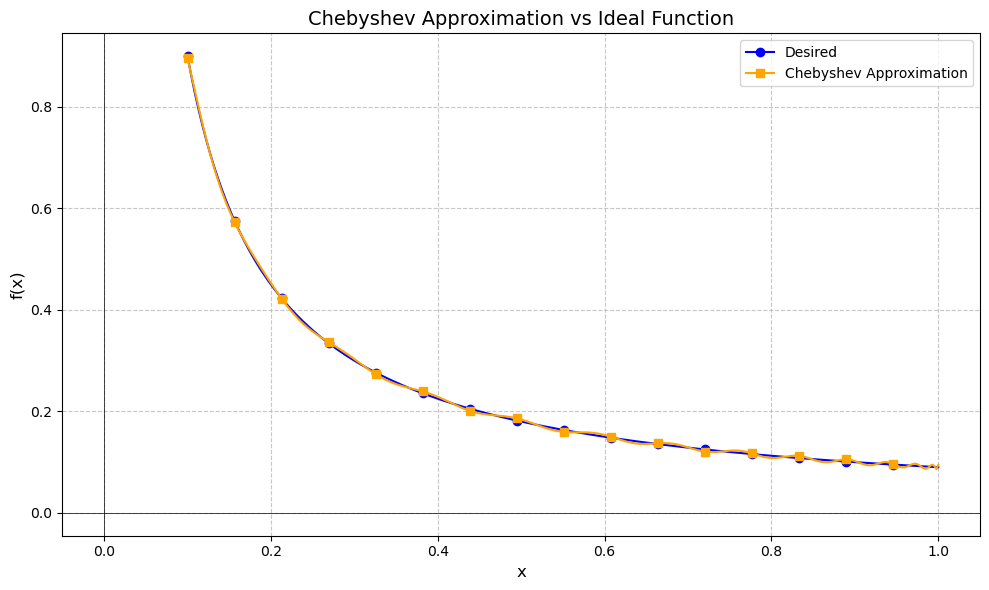

In [9]:
x = np.linspace(delta, 1, 400)
fx = scaling_factor/x
plt.figure(figsize=(10, 6))
plt.plot(x, fx, label='Desired', color='blue', marker='o', markevery=25)
plt.plot(x, cheb_poly_scaled(x), label=f'Chebyshev Approximation', color='orange', marker='s', markevery=25)
plt.title('Chebyshev Approximation vs Ideal Function', fontsize=14) 
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.5) # x
plt.axvline(0, color='black', linewidth=0.5) # y
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## QSVT example

In [ ]:

plot_approximation_comparison(d, kappa)


## Inversion

In [ ]:
A = np.array([[0.5, -0.25], [-0.25, 0.5]])
sigma_vals = np.linalg.svd(A, compute_uv=False)
A = A / (1.001*np.max(sigma_vals))  # Scale to have max singular value = 1
sigma_vals = np.linalg.svd(A, compute_uv=False)
print("Singular values of A:", sigma_vals)
b = np.array([1, 0]) # State |0>
degree = 51
kappa = np.max(sigma_vals) / np.min(sigma_vals)
print(f"Condition number kappa={kappa}")
solver = myQSVT(A, b, degree, kappa, nShots=1000)


u_qsvt = solver.solve()

if u_qsvt is not None:
    print("QSVT Solution (|x>):", u_qsvt)
    
    # Classical Verification
    x_exact = np.linalg.solve(A, b)
    u_exact = x_exact / np.linalg.norm(x_exact)
    print("Classical Solution: ", u_exact)
    print("Fidelity:           ", np.abs(np.dot(u_qsvt.conj(), u_exact))**2)